# Section 2: Reddit Submission Analysis

While I initially wanted to use the Twitter API to answer this question, I found the free version of the service to be quite restrictive, very limited in the number of Tweets that could be accessed and the time period over which I could search. 

Instead, I opted to use Reddit, a content aggregator site containing communities (subreddits) that are focused on different topics. Users can submit new posts to each subreddit, sort them communally, and comment on each post. While having these different community themes can be a bit challenging for analysis, they also provide unique insights into how users perceive the "fit" of content; what sorts of submissions fall under broad categories such as "news" (general news stories) and "politics" (general political news, with some US focus), or more niche communities like "woodworking" (discussion of the hobby) or "personalfinancecanada" (personal finance advice for Canada, specifically).

Reddit is much more generous in the way it allows users to access data. The Reddit API can be a bit difficult to use for my questions, but thankfully, there are also a number of API wrappers and separate repositories that can be used to query this same data in different ways.

For this project, I chose to use the [__PushShift API__](https://github.com/pushshift/api), which queries a growing repository containing Reddit submissions and comments going back to the site's creation in 2006. __By searching for all reddit submissions containing the keywords "climate change" and "global warming" in the last 10 years, I hope to  produce a dataset that may be used to analyze trends in language associated with these terms that is less sensitive to recent trends (unlike the Twitter API). __

### Assembling the dataset

To assemble a dataset using the PushShift API, I followed a similar framework to the excercises in class - querying the API using requests and iteratively writing the dataset in chunks. In contrasts to the datasets we used in class, however, it's easy for this dataset to be quite large - Reddit is one of the most popular websites on the internet and global warming / climate change is a hot button issue.

The PushShift API can return up to 500 submissions at a time, ordered in sequence from a start (in epoch time). To iteratively query all entries from a defined start date, I generated a function that:

1. Queries the PushShift API to return 500 submissions from a defined start date (1/1/2008)
2. Parse this JSON and write into a Pandas DataFrame
3. Add identifying columns corresponding to the searchterm used (climate change / global warming)
4. Return the epoch time (+1) of the last returned submission, which is the startdate of the next search.

Because this dataset had a potential to be quite large (in both length and number of variables), I also chose to write this into an SQL database to use memory more efficiently, as well as to serve as a basis for any subsequent analyses. I'm particularly interested in looking at the text of individual comments for each of these sources, but considering that some submissions have >10,000 comments each, this seemed likely to produce some computing headaches and could delay analysis of the project. Storing my data in SQL is likely to ease this sort of data collection if performed later.

In [1]:
import requests
import requests_cache
import time
import datetime
import pandas as pd
import sqlalchemy
import plotly
import plotly.plotly as py
import numpy as np
from plotly.graph_objs import *
import statsmodels.api as sm

# Setting plot format 
plotly.tools.set_credentials_file(username='ebatzer', api_key='BIJOCGPZqKooZ16thhcw')
%matplotlib inline
requests_cache.install_cache('reddit_cache')

C:\Users\ebatz\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [2]:
url = "https://api.pushshift.io/reddit/search/submission/"

# Sets dates - will run for all days between start and end
dstart = datetime.date(2008, 1, 1)
dend = datetime.date(2018, 1, 1)
steps = (dend - dstart).days

# Sets timesteps (start date, the first timestep, and the size between them, in epochs)
t0 = pd.to_numeric(time.mktime(time.strptime("2008/01/01 00:00:00 GMT", "%Y/%m/%d %H:%M:%S %Z")))
t1 = pd.to_numeric(time.mktime(time.strptime("2018/01/01 00:00:00 GMT", "%Y/%m/%d %H:%M:%S %Z")))

# Define the search subs function:
def search_subs(url, searchterm, sub, size, after, before):
    
    """
    Queries PushShift api to return data on Reddit Submissions with a given keyword
    
    Input:
        url(str): API URL of interest
        sub(str): The subreddits to focus on (can be left as Null for all subreddits)
        size(int): Total number of submission to return per query (max 500)
        after(int): Search for submissions after this date in epoch time
        before(int): Search for submissions before this data in epoch time
    
    """
    
    # Requests PushShift API
    req = requests.get(url, params = {"title" : searchterm,
                                     "after": after,
                                     "before": before,
                                     "subreddit": sub,
                                     "size": size})

    # Selects data element
    subdata = pd.DataFrame(req.json()['data'])
    
    # Adds identifying columns
    subdata["searchstart"] = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(after))
    subdata["searchend"] = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(before))
    subdata["keyword"] = searchterm
    
    return(subdata, subdata["created_utc"].iloc[-1])

Below is code that queries the API and produces an SQL database (subs.db) with two tables -- those submissions returned from searching for "climate change" or "global warming".

__Note: This code takes a while to process, in part because I chose to sleep after each request to avoid stressing the server. Running lines in the next two cells will cause the notebook to take at least 2-3 hours to run.__

In [3]:
engine = sqlalchemy.create_engine('sqlite:///data/subs.db')

search_utc = int(t0)
outputdf = dict()
count = 1

# while search_utc < int(t1) :
#     subs, search_utc = search_subs( 
#             url = url, 
#             searchterm = "climate change", 
#             sub = None, 
#             after = search_utc,
#             before = None,
#             size = 500)   

#     cols = ["author", "created_utc", "domain", "id", "num_comments",
#            "permalink", "score", "subreddit", "subreddit_id",
#            "title", "url", "searchstart", "searchend", "keyword"]

#     subs = subs[cols]
#     subs.to_sql("cctable", engine, if_exists = "append")
    
#     search_utc = search_utc + 1

#     if count % 25 == 0:
#         print("Current time is %s" % time.strftime('%Y-%m-%d %H:%M:%S',
#                                                    time.localtime(search_utc)))
        
#     count = count + 1
      
#     # Sleep to avoid over-requesting
#     time.sleep(1)

In [4]:
search_utc = int(t0)
outputdf = dict()
count = 1

# while search_utc < int(t1) :
#     subs, search_utc = search_subs( 
#             url = url, 
#             searchterm = "global warming", 
#             sub = None, 
#             after = search_utc,
#             before = None,
#             size = 500)
    
#     cols = ["author", "created_utc", "domain", "id", "num_comments",
#            "permalink", "score", "subreddit", "subreddit_id",
#            "title", "url", "searchstart", "searchend", "keyword"]
#     subs = subs[cols]
#     subs.to_sql("gwtable", engine, if_exists = "append")
    
#     search_utc = search_utc + 1

#     if count % 25 == 0:
#         print("Current time is %s" % time.strftime('%Y-%m-%d %H:%M:%S',
#                                                    time.localtime(search_utc)))
        
#     count = count + 1
      
#     # Sleep to avoid over-requesting
#     time.sleep(1)

## Initial Data Analysis and Summary Statistics

Before any in-depth analysis, I first decided to generate some relevant summary statistics to characterize general patterns. To begin, this dataset has 298,000 unique observations distribution over a large number of different subreddits and submitter ID's.

Knowing that discourse on the internet can often be monopilized by certain users and communities, I set out to determine:

- Which communities contained the greatest number of relevant submissions?
- Are certain communities more dominated by some users than others?
- What sources are these different submissions based on?

In [5]:
# Querying datasets

gwcounts = pd.read_sql("""SELECT subreddit, COUNT(subreddit) 
FROM gwtable
GROUP BY subreddit
ORDER BY COUNT(subreddit) DESC
""",
               con = engine)

cccounts = pd.read_sql("""SELECT subreddit, COUNT(subreddit) 
FROM cctable
GROUP BY subreddit
ORDER BY COUNT(subreddit) DESC
""",
               con = engine)

authors = pd.read_sql("""SELECT subreddit, COUNT(DISTINCT author) 
FROM gwtable
GROUP BY subreddit
ORDER BY COUNT(DISTINCT author) DESC
""",
               con = engine)

# Generating some basic summary statistics

gwcounts.columns = ['subreddit', 'gw_counts']
cccounts.columns = ['subreddit', 'cc_counts']
authors.columns = ['subreddit', 'authors']

keywords = pd.merge(gwcounts, cccounts)
keywords = pd.merge(keywords, authors)

keywords["total"] = keywords["cc_counts"] + keywords["gw_counts"]
keywords["gw_frac"] = keywords["gw_counts"] / keywords["total"]
keywords["cc_frac"] = keywords["cc_counts"] / keywords["total"]
keywords["aut_frac"] = keywords["authors"] / keywords["total"]

## How are submissions distributed across different communities?

To begin, I first looked at the distribution of the reddit submissions across different communities (subreddits). While an uneven distribution is to be expected (user activity in these different communities varies widely), a single subreddit containing >50% of all submissions might be problematic.

In fact, we do see a highly skewed distribution - many subreddits only contain a single hit in our search, but there are a number of highly popular communities. In general, "climate change" appears to be a more popular term than "global warming".

In [6]:
trace1 = Scatter(
    x=keywords.sort_values("total", ascending = False)["subreddit"],
    y=np.log(keywords.sort_values("total", ascending = False)["total"])
)

trace2 = Scatter(
    x=keywords.sort_values("cc_counts", ascending = False)["subreddit"],
    y=np.log(keywords.sort_values("cc_counts", ascending = False)["cc_counts"])
)

trace3 = Scatter(
    x=keywords.sort_values("gw_counts", ascending = False)["subreddit"],
    y=np.log(keywords.sort_values("gw_counts", ascending = False)["gw_counts"])
)

fig = plotly.tools.make_subplots(rows=1, cols=3)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)


fig['layout'].update(height=600, width=600, title='Total keyword mentions (log scale)')
py.iplot(fig, filename='simple-subplot')

C:\Users\ebatz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

C:\Users\ebatz\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log

C:\Users\ebatz\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:

divide by zero encountered in log



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



## Are some communities dominated by a small number of power users?

The prevalence of individual "power users" in some communities may produce significant issues for any text analysis - if a majority of documents in a corpus are produced by a single user, any analysis may be biased towards trends present within this user's language, failing to be representative of the whole.

These plots, where points vary in size based on the number of submissions and are colored by the frequency of keyword use, show the relationship between total number of posts and the number of unique authors responsible for those posts. While there's an apparent linear relationship between these two variables, a number of posts from some communities are being submitted by a very small number of users. This isn't unexpected, given patterns of content distribution on the internet, but it is likely important to remove these from our analysis when performing any sort of text analysis or classification.

C:\Users\ebatz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in log

C:\Users\ebatz\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

divide by zero encountered in log

C:\Users\ebatz\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning:

divide by zero encountered in log



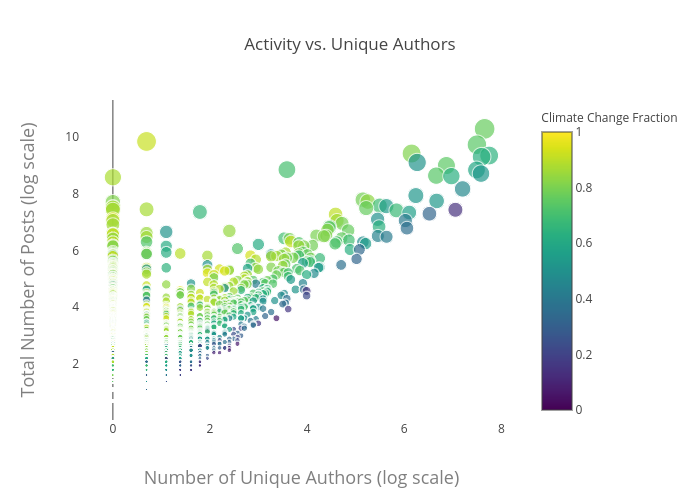

In [7]:
# Create traces
data = Data([
    Scatter(
        y= np.log(keywords.sort_values("total", ascending = False)["total"]),
        x= np.log(keywords.sort_values("total", ascending = False)["authors"]),
        marker=Marker(
            size= np.log(keywords.sort_values("total", ascending = False)["total"]) * 2,
            cmax=1,
            cmin=0,
            color= keywords.sort_values("total", ascending = False)["cc_frac"],
            colorbar=ColorBar(
                title='Climate Change Fraction'
            ),
            colorscale='Viridis'
        ),
        mode='markers',
        name='Markers',
        text=keywords.sort_values("total", ascending = False)["subreddit"],
        textposition='bottom',
        showlegend = False)
])


layout = Layout(
    title='Activity vs. Unique Authors',
    xaxis=dict(
        title='Number of Unique Authors (log scale)',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        ),
        showgrid=False
    ),
    yaxis=dict(
        title='Total Number of Posts (log scale)',
        titlefont=dict(
            size=18,
            color='#7f7f7f'
        ),
        showgrid=False
    )
)

fig = Figure(data = data, layout = layout)
py.image.ishow(fig)

### Which subreddits talk the most about climate change and global warming?

Because Reddit data is neatly categorized into defined communities, we may be able to make some inferences based on patterns of keyword usage between different groups. The following tables display:

- Subreddit: Community in which posts were found
- GW_counts/CC_counts: The total number of submissions in each community for "global warming" and "climate change" keywords, respectively.
- Authors: The total number of unique authors for posts found in each subreddit.
- Total: Total number of posts found in each subreddit
- GW_frac/CC_frac/AUT_frac: The fraction of posts that contain the terms "global warming", "climate change", or the ratio between total number of posts and unique authors.

I see two key types of communities in this dataset - those that are advocates for climate science, such as "environment", "EcoInternet", "climate", and "science" - and those that are antagonist or question questioning - such as "climateskeptics" or "AskReddit". However, as noted before, we also see that some communities are dominated by single groups; namely, "POLITIC" and "EcoInternet", which are actually news aggregators where an automated program submits headlines to their corresponding community.

In [8]:
keywords.sort_values("total", ascending = False).iloc[:10,]

,subreddit,gw_counts,cc_counts,authors,total,gw_frac,cc_frac,aut_frac
0,environment,6876,22549,2109,29425,0.233679,0.766321,0.071674
12,EcoInternet,1586,17293,2,18879,0.084009,0.915991,0.000106
2,politics,4343,12488,1800,16831,0.258036,0.741964,0.106946
7,climate,2357,9978,469,12335,0.191082,0.808918,0.038022
3,reddit.com,4148,7340,2316,11488,0.361072,0.638928,0.201602
4,science,4047,6955,1981,11002,0.367842,0.632158,0.180058
1,climateskeptics,4374,4626,526,9000,0.486000,0.514000,0.058444
10,worldnews,2046,6026,960,8072,0.253469,0.746531,0.118930
8,POLITIC,2072,4916,36,6988,0.296508,0.703492,0.005152
6,AskReddit,2811,4107,1784,6918,0.406331,0.593669,0.257878


If we remove these communities dominated by a small number of users (I'm assuming a unique author fraction of >.01 is appropriate) or a limited number of submission (my threshold is > 2000), trends become easier to interpret. The table below shows the communities that have the highest usage of "climate change" in their submissions. These communities may be described as "pro-science" and are focused on disseminating climate science news (though "collapse" has a distinctly apocalyptic tone).

In [9]:
keywords[(keywords["total"] > 2000) & (keywords["aut_frac"] > .01)].sort_values("cc_frac", ascending = False).iloc[:5,]

,subreddit,gw_counts,cc_counts,authors,total,gw_frac,cc_frac,aut_frac
31,climatechange,383,1884,190,2267,0.168946,0.831054,0.083811
7,climate,2357,9978,469,12335,0.191082,0.808918,0.038022
27,collapse,512,1904,172,2416,0.211921,0.788079,0.071192
0,environment,6876,22549,2109,29425,0.233679,0.766321,0.071674
10,worldnews,2046,6026,960,8072,0.253469,0.746531,0.118930


On the other hand, the communities that most use the term "global warming" are distinguished by either climate skepticism or an uninformed perspective. "Climateskeptics" and "conspiracy", as one might expect, are major hubs for climate skeptics and conspiracy theorists on Reddit, who may be more likely to view climate science as a politically motivated hoax. "Askscience" and "explainlikeimfive", on the other hand, are dominated by users seeking new information - I think it's likely that these communities are represented by users who have little knowledge of climate science and associated terminology.

I am a bit baffled as to why the term "global warming" is well represented in "showerthoughts", a mostly humor-oriented community focused on the epiphanies we get while taking a shower. Perhaps "global warming" is a term that lends itself better to jokes.

In [10]:
keywords[(keywords["total"] > 2000) & (keywords["aut_frac"] > .01)].sort_values("gw_frac", ascending = False).iloc[:5,]

,subreddit,gw_counts,cc_counts,authors,total,gw_frac,cc_frac,aut_frac
11,Showerthoughts,1897,1644,1340,3541,0.535724,0.464276,0.378424
1,climateskeptics,4374,4626,526,9000,0.486000,0.514000,0.058444
15,conspiracy,1338,1462,512,2800,0.477857,0.522143,0.182857
5,askscience,2887,3190,1958,6077,0.475070,0.524930,0.322198
16,explainlikeimfive,1090,1226,785,2316,0.470639,0.529361,0.338946


## Where do these posts come from?

Furthermore, we can find some interesting trends in where users are finding content for their posts. If we remove posts that are based on user-submitted text or images ("self.subreddit", "imgur.com", and "reddit.com"), we see that popular links include content on "youtube" and major news publications on both sides of the political spectrum. Perhaps the most significant is "wattsupwiththat.com", a climate skepticism website that I wasn't aware of prior to this project.

In [11]:
domaincounts = pd.read_sql("""SELECT domain, COUNT(domain) 
FROM gwtable
GROUP BY domain
ORDER BY COUNT(domain) DESC
""",
               con = engine)

news = domaincounts[~(domaincounts["domain"].str.contains("self.")) &
             ~(domaincounts["domain"] == "reddit.com") & 
             ~(domaincounts["domain"] == "imgur.com") & 
             ~(domaincounts["domain"] == "i.imgur.com") & 
             ~(domaincounts["domain"] == "i.redd.it")]

news.head(10)

,domain,COUNT(domain)
0,youtube.com,2980
4,theguardian.com,1910
10,dailycaller.com,1053
11,nytimes.com,1024
12,washingtonpost.com,939
13,independent.co.uk,905
15,wattsupwiththat.com,830
16,dailymail.co.uk,725
17,thinkprogress.org,664
18,scientificamerican.com,648


# Term Frequencies and Document Classification

To better understand patterns of language associated with the keywords "climate change" and "global warming", I set out to analyze term frequencies within these submissions and produce a binary classifier that would be able to distinguish which keyword is most likely to be used based on other language found in a submission title.

## Subsetting this original corpus:

This large, unedited corpus contains a bunch of relevant information, but may benefit from some subsetting prior to natural language processing. 

Some potential issues:


__1. Text length:__ When computing frequency-based metrics (such as tf-idf) and document similarity, large differences in text length can be problematic.

__2. Repeat entries:__ Reddit supports cross-posting, a method that allows users to select submissions from one forum and link them to another. For purposes of classification, duplicate entries can present issues, effectively increasing the weight of a certain text entry.

__3. User dominance:__ As previously noted, some power users may exert strong influence on any observed patterns, if there are particular writing styles or word associations that are representative of a certain news source, for example, rather than a pattern of interest.

In [12]:
gwtitles = pd.read_sql("""SELECT subreddit, domain, title, url, keyword
FROM gwtable
""",
               con = engine)

cctitles = pd.read_sql("""SELECT subreddit, domain, title, url, keyword
FROM cctable
""",
               con = engine)

corpus = pd.concat([gwtitles, cctitles])
corpus.reset_index(inplace = True)
print(corpus.shape)
corpus.head()

(298000, 6)


,index,subreddit,domain,title,url,keyword
0,0,reddit.com,ocregister.com,Editorial: Global warming 'consensus' a fiction,http://www.ocregister.com/opinion/global-gore-...,global warming
1,1,reddit.com,thedailybanter.com,Global Warming denial industry still going strong,http://www.thedailybanter.com/tdb/2008/01/glob...,global warming
2,2,science,sciencedaily.com,Declining Water Levels In The Great Lakes May ...,http://www.sciencedaily.com/releases/2007/12/0...,global warming
3,3,reddit.com,ap.google.com,The chaotic effects of global warming? Record ...,http://ap.google.com/article/ALeqM5jv320qXrVAV...,global warming
4,4,reddit.com,fastcompany.com,Reverend Cizik: Tries to convince 30 Million E...,http://www.fastcompany.com/magazine/106/moving...,global warming


I first began by subsetting this corpus to only those entries that are represented by communities that were not previously identified as being too dominated by a small group of users (unique author fraction > .01). Then, I removed all duplicated title entries and calculated their total word lengths.

C:\Users\ebatz\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\ebatz\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BCAEC7F128>]],
      dtype=object)

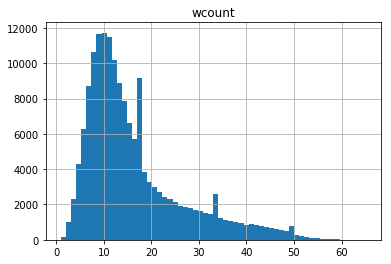

In [13]:
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Finding those forums with a very small number of submitters:
to_exclude = keywords["subreddit"][keywords["aut_frac"] <= .01]
corpus_edited = corpus[~corpus.subreddit.isin(to_exclude)]

# Dropping all duplicates:
corpus_edited.drop_duplicates("title", inplace = True)

# Calculating text lengths:
def CountWords(x):
    """Counts TextBlob words for strings"""
    wordcount = len(TextBlob(str(x)).words)
    return(wordcount)

corpus_edited["wcount"] = [CountWords(x) for x in corpus_edited["title"]]
corpus_edited.hist("wcount", bins = 60)

Because word counts showed a heavily right-skewed distribution, I thought it'd be best to focus on a group of submissions that contained roughly equivalent lengths. I'm not entirely sure what the best protocol would be for this subsampling, but I chose to focus on the group of submissions with lengths between the interval of 15 and 20 words. Longer sentences seemed likely to be better for this analysis, and an overly large sample size could slow down model fitting.

Limiting this corpus to those entries yielded a dataset of roughly 30,000 submissions, which I reduced to 20,000 total (10,000 samples each containing the keywords "global warming" and "climate change", respectively).

In [14]:
# Adding bounds for word length:
corpus_edited = corpus_edited[(corpus_edited["wcount"] >= 15) & (corpus_edited["wcount"] <= 20)]

# Counting the number of entries for each group
corpus_edited[["index", "keyword"]].groupby("keyword").agg(['count'])

,index
,count
keyword,
climate change,18298
global warming,10294


In [15]:
# Randomly sampling entries
import random
corpus_edited.reset_index(inplace = True)
ccindex = random.sample(list(corpus_edited.index.values[corpus_edited["keyword"] == "climate change"]), 10000)
gwindex = random.sample(list(corpus_edited.index.values[corpus_edited["keyword"] == "global warming"]), 10000)

# Indices to keep:
to_keep = ccindex + gwindex
corpus_edited = corpus_edited.iloc[to_keep]

# Randomizes row position:
corpus_edited = corpus_edited.sample(frac=1)

## Text Processing

Then, using modified functions from lecture notes and homework 6, I cleaned submission titles to remove stopwords, lemmatize text, and strip out the terms "global warming" and "climate change". Because these terms are already present as a distinction between text in the dataset (by virtue of how the dataset was assembled) they may skew term frequency analysis. Predicting what terms will be used also forms the basis of a subsequent classification problem. 

In [16]:
tokenize = nltk.word_tokenize

def stem(tokens, stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: 
        text(chr): A string of text
    Output: 
        lemma(list): A list of strings (lemmata)
    """
    return stem(tokenize(text))

stopwords = stopwords.words("english")

def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag.
    
    Input:
        tag(chr): Brown POS tag
        
    Output:
        tag(chr): WordNet POS tag
    
    """
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

def cleanBlob(blob):
    """Cleans text blobs to only contain relevant words and characters
    
    Input:
        blob(TextBlob): A raw text blob
        
    Output:
        newblob(TextBlob): A cleaned text blob
    """
    
    # Removes stopwords
    new_text = " ".join(w for w in blob.words if w.lower() not in stopwords)

    # Removes any characters that aren't alphabetical or whitespace
    new_text = re.sub(r"[^A-Za-z\s\t\n\'\.]+", '', new_text.lower())
    
    # Removes the occurance of "global warming" or "climate change"
    new_text = re.sub("climate change", '', new_text)
    new_text = re.sub("global warming", '', new_text)
    
    # Reassigns textblob with cleaned text
    new_text = re.sub("  +", ' ', new_text)
    newblob = TextBlob(new_text)
    
    # Converts tags to lemmatize correctly
    tags = [wordnet_pos(x[1]) for x in newblob.pos_tags]
    
    # Lemmatizes words in the textblob
    newblob = " ".join(x.lemmatize(t) for x, t in zip(newblob.words, tags))
    newblob = TextBlob(newblob)
    
    # Returns cleaned blob
    return(newblob)

## Fitting TF-IDF and Term Frequency Analysis

In [17]:
blobs = [TextBlob(x) for x in corpus_edited["title"]]
cleanblobs = [cleanBlob(x) for x in blobs]
corpus_edited["class_text"] = [str(x) for x in cleanblobs]
text = np.array(corpus_edited["class_text"].tolist())

def fit_tfidf(docs):
    
    """Fit Tf-IDF function
    
    Input:
        docs(str): A list of strings to assemble TF-IDF matrix
    
    Output:
        mat(tfidf): A TF-IDF object
        cols(str): String of feature names for TF-IDF object
    """
    
    # Fits IDF
    tfit = TfidfVectorizer(smooth_idf=True, analyzer="word").fit(docs)
    
    # Returns Matrix and Feature names
    mat, cols = tfit, tfit.get_feature_names()
    return(mat, cols)

tfit, cols = fit_tfidf(text)
all_tf = pd.DataFrame(tfit.transform(text).A)
all_tf.columns = cols
all_tf.head()

,aa,aaa,aaaaaaaaaaaaahhhh,aagenda,aang,aapl,aaps,aaron,ab,abandon,...,zofeen,zombie,zomfg,zone,zoo,zoonotic,zoos,zuckerberg,zuesse,zunger
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### What terms are associated with submissions containing different keywords?

Term frequency analysis can give some qualitative insights into word associations between different terms. Here, figures show the terms that have the largest absolute difference in frequency between submissions containing the term "global warming" and those containing the term "climate change".

In [18]:
keyword_tf = all_tf.groupby(corpus_edited["keyword"]).agg("mean").transpose()
keyword_tf["diff"] = keyword_tf["climate change"] - keyword_tf["global warming"]

Among the terms that appear to be more commonly associated with the keyword "climate change" are "trump", "manmade", "increase", "global", "epa". Without any sort of quantitative analysis, these suggest that there are patterns of term use that correspond with what I would consider to be the common viewpoint associated with a more science-informed perspective. If pressed, I would assume that many of these submissons are focused on the political responses to global climate change.

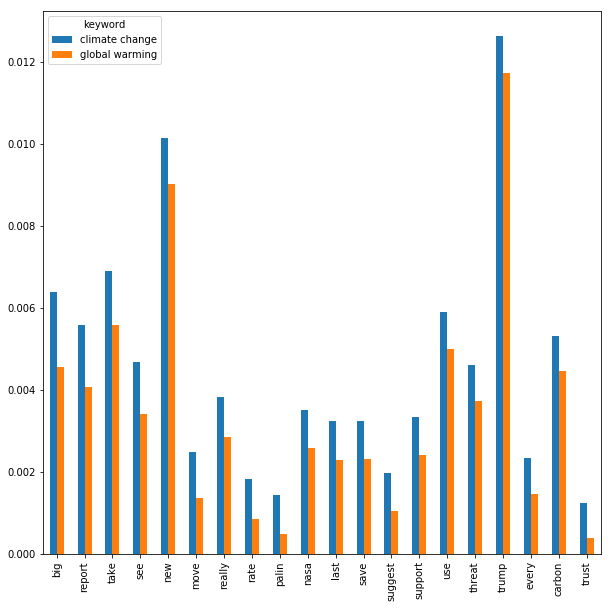

In [19]:
keyword_tf.sort_values("diff", ascending=False).iloc[:20, :2].plot(kind = "bar", figsize = [10,10])

In converse, the terms that appear more commonly associated with the keyword "global warming" are "cold", "attack", "weather", "hoax", and "bad", along similar terms to the subjects discussed above, like "bill". I think it's likely that this term is used when the subject of a submission is focused on drawing attention to climate skepticism. However, it's important to note that many of these terms have substantial overlap with one another, and may resist easy generalization.

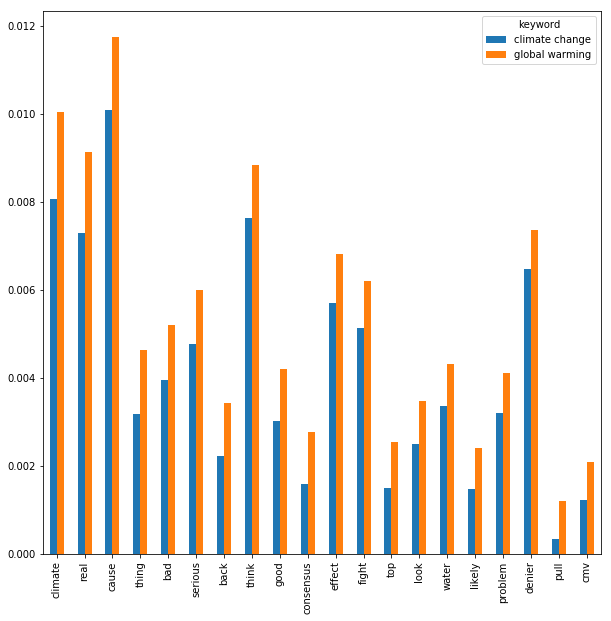

In [20]:
keyword_tf.sort_values("diff", ascending=True).iloc[:20, :2].plot(kind = "bar", figsize = [10,10])

## Naive Bayes Classification

To better understand how keyword use is correlated with language, I constructed a simple Naive Bayes classifier designed to predict what keyword label a submission would use, after having this labelled removed from the string.

To do so, I opted for SciKit-Learn's BernoulliNB function, which produces a Naive Bayes classifier for a [1,0] response. To tune this model, I used 10-fold cross validation to assess changes in model accuracy depending on the "alpha" smoothing parameter in the model.

In [21]:
#K-fold cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=0) # Creates a K-fold function with 10 splits
target = np.array(corpus_edited["keyword"].tolist()) # Generates target label vector
kf.get_n_splits(text) # Generates random splits
kf.split(text) # Applies to text

# Running accuracy tests over a range of alpha parameter value (0-1)
mod_accuracy = []
mod_alpha = []
alphas = np.linspace(0, 2, 20)

for alpha_val in alphas:
    
    for train_index, test_index in kf.split(text):

        # Subsetting arrays into test/training sets for each fold:
        X_train, X_test = text[train_index], text[test_index]
        y_train, y_test = target[train_index], target[test_index]
        tfit, cols = fit_tfidf(X_train)
        
        # Trains classifier on training data
        clf = BernoulliNB(alpha=alpha_val).fit(tfit.transform(X_train), y_train)
        
        # Constructs new IDF of test data, 
        X_new_tfidf = tfit.transform(X_test)

        predicted = clf.score(X_new_tfidf,  y_test)
        mod_alpha.append(alpha_val)
        mod_accuracy.append(predicted)

C:\Users\ebatz\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



Assessing model output in this way suggests that no change to the default alpha parameter value (1) is necessary, though differences in model accuracy and variance aren't particularly substantial.

Moreover, it seems that this classification methods performs significantly better than just random guessing (an expected 50% accuracy rate based on the structure of the data). At the best model performance, I achieved an accuracy score of roughly 68.5%

### Model Accuracy:

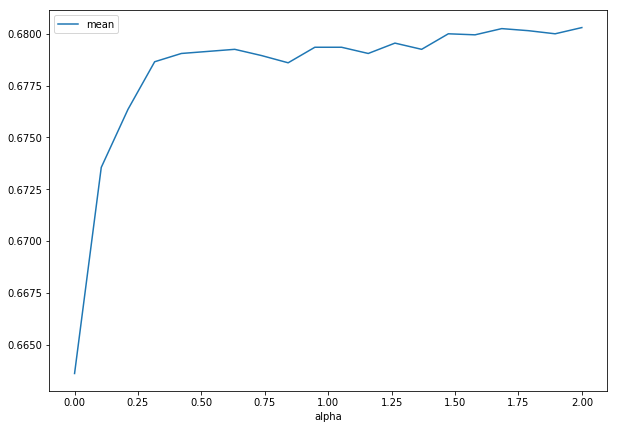

In [22]:
mod_output = pd.DataFrame({"alpha": mod_alpha, "acc": mod_accuracy})
output_summary = pd.DataFrame({"mean": mod_output.groupby("alpha")["acc"].mean(),
 "var": mod_output.groupby("alpha")["acc"].var()}).reset_index()

output_summary.plot(x = "alpha", y = "mean", figsize=[10,7])

### Accuracy Variance

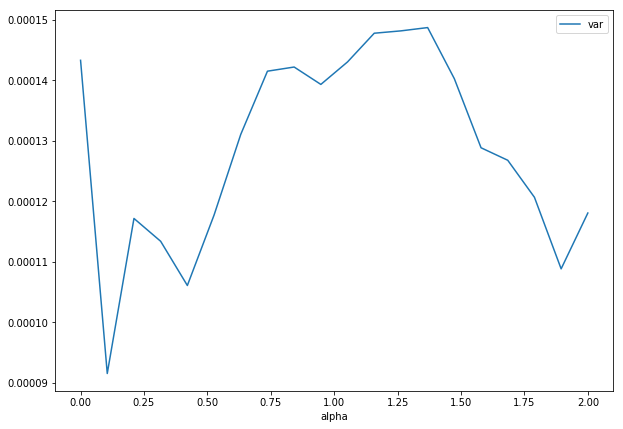

In [23]:
output_summary.plot(x = "alpha", y = "var", figsize=[10,7])

### Confusion Matrix

Construction of the confusion matrix also confirms that this model does seem to perform better than the null, and doesn't seem to be showing a greater affinity for one label over another:

In [24]:
# Splits data into a 90:10 train:test split
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=.1, random_state=0)

# Generates IDF
tfit, cols = fit_tfidf(X_train)

# Fits classifier and predicts new labels
clf = BernoulliNB(alpha=1).fit(tfit.transform(X_train), y_train)
X_new_tfidf = tfit.transform(X_test)
y_pred = clf.predict(X_new_tfidf)

# Generates confusion matrix
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))
confusion_matrix.columns = ["Pred: Climate Change", "Pred: Global Warming"]
confusion_matrix.index = ["Obs: Climate Change", "Obs: Global Warming"]
confusion_matrix

,Pred: Climate Change,Pred: Global Warming
Obs: Climate Change,613,341
Obs: Global Warming,300,746


### Feature comparison

Extracting the feature log probabilities of this model suggests some interesting associations. "Trump", for example, is one of the more common phrases associated with the term "climate change", as is "world", and "scientist".

In [25]:
features = pd.DataFrame({"CC": clf.feature_log_prob_[0],
                         "GW": clf.feature_log_prob_[1]})
features.index = cols
features.sort_values("CC", ascending=False).head()

,CC,GW
trump,-2.564949,-3.440597
say,-2.815033,-2.907716
new,-2.985616,-3.149436
world,-2.994407,-3.304021
climate,-3.116338,-3.144242


Whiile posts are reported to be more likely to have the label "global warming" if they focus on terms like "cause", "year", as well as "scientist", like the above.

In [26]:
features.sort_values("GW", ascending=False).head()

,CC,GW
cause,-3.461325,-2.681714
say,-2.815033,-2.907716
scientist,-3.133948,-2.934661
year,-3.526803,-3.059824
could,-3.504497,-3.116143


## Will this classifier also predict term use for President Trump's Tweets correctly?

Just as a small proof-of-concept (and to check that my classifier functions runs correctly), I attempted to classify the text of the Tweets by President Trump first mentioned at the beginning of Section 1. It appears that the classifier appropriately modifies text and correctly predicts the use of the term "global warming" in both Tweets.

A more significant comparison is necessary to make any concrete conclusion, but this finding suggests that these patterns of speech associated with different keyword use may be common across multiple internet sources.

In [27]:
tquotes = ["The concept of global warming was created by and for the Chinese in order to make U.S. manufacturing non-competitive.",
 "In the East, it could be the COLDEST New Year’s Eve on record. Perhaps we could use a little bit of that good old Global Warming that our Country, but not other countries, was going to pay TRILLIONS OF DOLLARS to protect against. Bundle up!"]

blobs = [TextBlob(x) for x in tquotes]
cleanblobs = [cleanBlob(x) for x in blobs]
tquotes_clean = [str(x) for x in cleanblobs]
tquotes_clean

['concept create chinese order make u.s manufacturing noncompetitive',
 'east could coldest new year eve record perhaps could use little bit good old country country go pay trillion dollar protect bundle']

In [28]:
X_new_tfidf = tfit.transform(tquotes_clean)
print(clf.predict(X_new_tfidf))

['global warming' 'global warming']


# Conclusions:

Together, these analyses produce tentative support for the notions that:

__1. There is a seasonal pattern of interest in climate science, related to temperature patterns.__

__2. Use of the terms "global warming" and "climate change" correlates with patterns of language and perspective.__

These findings reflect key barriers to communication that may guide the ways in which environmental scientists engage in discussion about climate science. In response to seasonal patterns of interest, for example, researchers may benefit from timing their outreach to correlate with periods of attention, or increase efforts during summer months when interest dwindles.

This analysis may also encourage scientists to think more carefully about their choice of terminology. While the term "global warming" is not necessarily wrong, it may convey consequences that aren't predicted by climate science. As a result, debate between individuals who prefer to use the term "global warming" and those who prefer "climate change" may start from fundamentally different assumptions. Attempting to come to common ground on terminology may be a critical step in developing more productive conclusions on how to address global climate change.

Overcoming recency bias and use of misleading language is difficult, but I believe that this sort of analysis can help identify patterns that may eventually lead to improved methods of science communication.
